In [16]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [17]:
import re 
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cff

In [18]:
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cff.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [19]:
ds = pd.read_csv("amazon.csv")

In [20]:
ds = ds.sort_values("wilson_lower_bound", ascending = False)
ds.drop('Unnamed: 0',inplace =True,axis =1)

In [21]:
def missing_values(ds):
    na_columns_ =[col for col in ds.columns if ds[col].isnull().sum()>0]
    n_miss = ds[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_=(ds[na_columns_].isnull().sum() / ds.shape[0]*100).sort_values(ascending=True)
    missing_ds = pd.concat([n_miss,np.round(ratio_,2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_ds = pd.DataFrame(missing_ds)
    return missing_ds

In [22]:
def checking_dataset(ds, head=5,tail=5):
    print ('Rows:{}'.format(ds.shape[0]))
    print ('Colums:{}'.format(ds.shape[1]))
    print (ds.duplicated().sum())
    print (missing_values(ds))
checking_dataset(ds)

Rows:4915
Colums:11
0
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02


In [23]:
def check_class(dataframe):
    nunique_ds = pd.DataFrame({'Variable': dataframe.columns,
                                'Classes': [dataframe[i].nunique() \
                                            for i in dataframe.columns]})
    nunique_ds = nunique_ds.sort_values('Classes',ascending=False)
    nunique_ds = nunique_ds.reset_index(drop=True)
    return nunique_ds
check_class(ds)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

constraints = ['#B34D22','#EBE00C','#1FEB0C','#0C92EB', '#EB0CD5']

def categorical_variable(ds, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage'),
                        specs=[[{"type":"xy"},{"type":"domain"}]])
    
    fig.add_trace(go.Bar(y=ds[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in ds[column_name].value_counts().index],
                         text=ds[column_name].value_counts().values.tolist(),
                         textfont=dict(size=14),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=constraints,
                                     line=dict(color=constraints[0], 
                                               width=1))),
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=ds[column_name].value_counts().keys(),
                         values=ds[column_name].value_counts().values,
                         textfont=dict(size=18),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(colors=constraints)),
                  row=1, col=2)
    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    iplot(fig)


In [25]:
rt = lambda x: re.sub("[^a-zA-Z]",' ',str(x))
ds["reviewText"] = ds["reviewText"].map(rt)
ds["reviewText"] = ds["reviewText"].str.lower()
ds.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ds[['polarity', 'subjectivity']] = ds['reviewText'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

analyzer = SentimentIntensityAnalyzer()

for index, row in ds.iterrows():
    score = analyzer.polarity_scores(row['reviewText'])
    if score['neg'] > score['pos']:
        ds.loc[index, 'sentiment'] = "Negative"
    elif score['neg'] < score['pos']:
        ds.loc[index, 'sentiment'] = "Positive"
    else:
        ds.loc[index, 'sentiment'] = "Neutral"


In [27]:
ds[ds['sentiment']=='Positive'].sort_values("wilson_lower_bound",
                                            ascending=False).head(5)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,polarity,subjectivity,sentiment
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,0.163859,0.562259,Positive
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,0.103870,0.516435,Positive
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,0.212251,0.505394,Positive
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,0.143519,0.494207,Positive
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109,0.172332,0.511282,Positive


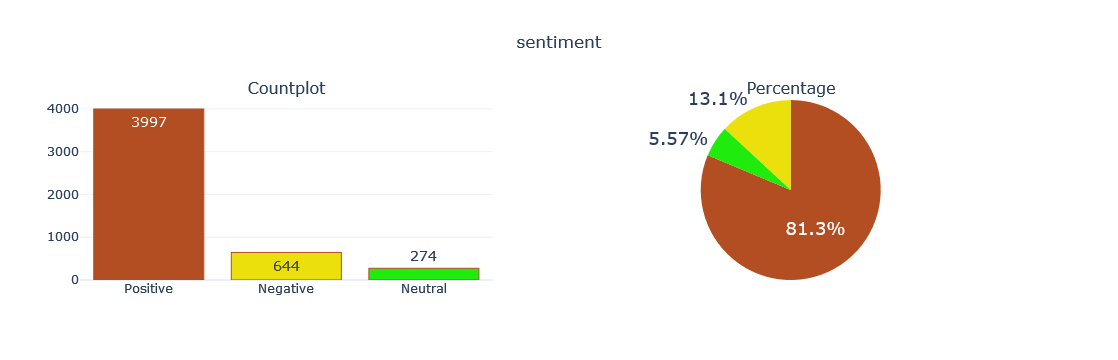

In [28]:
categorical_variable(ds,'sentiment')

In [29]:
sentiment_scores = {'Positive': 10, 'Negative': 1, 'Neutral': 5}
ds['sentiment_score'] = ds['sentiment'].map(sentiment_scores)
average_score = ds['sentiment_score'].mean()
rating_out_of_10 = (average_score)
print("Rating out of 10 based on reviews:", rating_out_of_10)

Rating out of 10 based on reviews: 8.542014242115972
